<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [235]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [236]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-03-01 21:43:03--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-03-01 21:43:03 (12.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [237]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [238]:
df.shape

(346, 10)

### Convert to date time object 

In [239]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [240]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [241]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



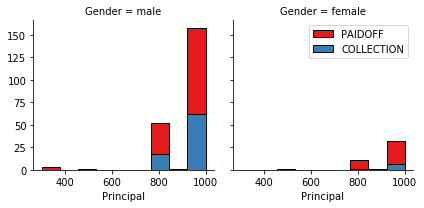

In [242]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

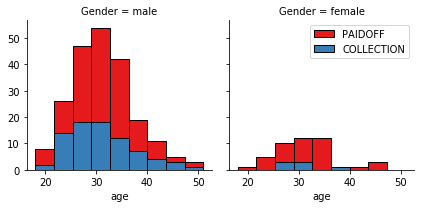

In [243]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

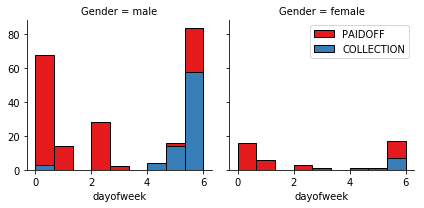

In [244]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [245]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [246]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [247]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [248]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [249]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [250]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [251]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [252]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [253]:
X= preprocessing.StandardScaler().fit(X).transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Final Capstone Project to build a classifer to predict a customer default
## Prepared by Aaqib Shah, Financial Engineer, RBC Quant Models Toronto

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

#### We will use four ML Approaches to predict defaults using Train and Test Datasets
#### Appoaches- KNN, Decision Tree, SVM and Logistic Regression

# Approach 1- KNN
### First we have to download data, clean and tranformation it

In [265]:
##################################################################################
## Cleaning and Transforming the Data.
##################################################################################
# First let's download the libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

##################################################################################
## Download the input data
##################################################################################
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
## Load data from CSV file
df = pd.read_csv('loan_train.csv')
df.head()
## Count a data matrix
df.shape

##################################################################################
## Data conversion
##################################################################################
##Convert to data time 
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

##################################################################################
## Data visualization and preprocessing
##################################################################################

df['loan_status'].value_counts()

## Pre-processing: Feature selection/extraction
## Lets look at the day of the week people get the loan
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)

## lets use Feature binarization to set a threshold values less then day 4, as we see 
## that people who get the loan at the end of the week dont pay it off. 
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

##################################################################################
## Convert Categorical features to numerical values
##################################################################################
## Lets look at gender:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

## Lets convert male to 0 and female to 1:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

## Education
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

## X heads
df[['Principal','terms','age','Gender','education']].head()

## Use one hot encoding technique to convert categorical varables to binary variables 
## and append them to the feature Data Frame
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()
##################################################################################
## Feature selection- Lets defind feature sets, X and y

X_traindata = Feature
y_traindata = df['loan_status'].values
## Note: We will normalize the data after test train split, although it will not make any difference
##################################################################################

--2020-03-01 21:53:14--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-03-01 21:53:14 (12.1 MB/s) - ‘loan_train.csv’ saved [23101/23101]



## Find the best k and use it to find KNN

In [266]:
##################################################################################
## Split the data into test/train to find a best k
##################################################################################
from sklearn.model_selection import train_test_split

## Attention: This X_train and y_train is different than X_traindata and y_traindata which is our entire data

X_train, X_test, y_train, y_test = train_test_split( X_traindata, y_traindata, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

## Normalizing Data. 
X_traindata = preprocessing.StandardScaler().fit(X_traindata).transform(X_traindata)

##################################################################################
## Find the best k to build the model with the best accuracy
##################################################################################
from sklearn.neighbors import KNeighborsClassifier # import KNN Classifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics # for evaluation metrics
storek=[]
optk=[]
from sklearn.neighbors import KNeighborsClassifier
for k in range(1,15):
## Train Model using training data
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
## Loss Prediction on the trained model using test data
    yhat_optk = neigh.predict(X_test)
    yhat_optk[0:5]
## Using accuracy score as a matric to determine an optimal "k" for KNN approach
    pred_test_score = metrics.accuracy_score(y_test,yhat_optk)
    optk.append(metrics.accuracy_score(y_test,yhat_optk)) # storing the accuracy vector
    storek.append(k)

max_AR = max(optk)  # Find the best (max) Accuracy Rate
kf = storek[optk.index(max_AR)]  # Find the k value corresponding to the maximum AR value
##################################################################################
## Printing the best k
print ("optimal k:", kf, "when AR is max:", max_AR)

##################################################################################
## Using KNN Approach with best k to train the model on the entire training data
##################################################################################
## Apply optimal k for training data (346 data records)
neigh_optimal = KNeighborsClassifier(n_neighbors = kf).fit(X_traindata,y_traindata)
##################################################################################

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
optimal k: 9 when AR is max: 0.7428571428571429


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


# Approach 2- Decision Tree

In [267]:
##################################################################################
## Modeling fitting training set and predicting for test set
##################################################################################
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
##################################################################################
## For Decision Tree, selecting best max_depth is important for best results
## using train test split data set (used for  best k in KNN)

## Initiating a loop with range from 3 (default) to 15 to determine the best depth
## Scaling the depth from 3 to 15 with 1 step increase per cycle

max_depths = np.linspace(3, 15, 13, endpoint=True)
storemd = [] # for storing max_depth
optmd = [] # for storing optimal max_depth
## Looping the max_depth for optimal number, choosing entropy for better info gain
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    dt.fit(X_train, y_train)
    yhat_optmd = dt.predict(X_test)
  
    # Using Accuracy Ratio to measure 
    pred_test_score = metrics.accuracy_score(y_test,yhat_optmd)
    optmd.append(pred_test_score) # storing the accuracy vector
    storemd.append(max_depth) # storing the max depth points

max_AR = max(optmd)  # Find the best (max) Accuracy Rate
mdf = storemd[optmd.index(max_AR)] # Find the best max_depth corresponding to Accuracy
   
##################################################################################
## Printing the best k
print ("optimal mdf:", mdf, "when AR is max:", max_AR)
##################################################################################

##################################################################################
# Modeling Decision Tree on overall Train Dataset; using best max depth
deftree= DecisionTreeClassifier(criterion="entropy", max_depth=mdf) # best max depth
deftree
deftree.fit(X_traindata, y_traindata)
##################################################################################

optimal mdf: 6.0 when AR is max: 0.7714285714285715


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Approach 3- Support Vector Machine

In [268]:
##################################################################################
## SVM- Using the entire Training Data Set
##################################################################################

##################################################################################
from sklearn import svm
clf = svm.SVC(kernel='rbf') # rbf is practictioner's preferred choice and optimal
clf.fit(X_traindata, y_traindata)
##################################################################################

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Approach 4- Logistic Regression

In [269]:
##################################################################################
# Prediction loss using Logistic Regression
##################################################################################


##################################################################################
from sklearn.linear_model import LogisticRegression 
# newton-cg solver (with default tol=0.0001) is preferred than linear solver, per its L2 Regularization
## and quadratic approximation
LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_traindata, y_traindata)
##################################################################################

# Model Evaluation (all 4 Approaches) using Test Dataset 

In [270]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [271]:
## Run the test data for evaluation
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-03-01 21:53:15--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-03-01 21:53:15 (398 MB/s) - ‘loan_test.csv’ saved [3642/3642]



## Load Test set for evaluation 

### Load Test Data Set and tranform it to align with the Train Data Set

In [272]:
##################################################################################
## Now using the Loan Test Data to measure the model performance
##################################################################################

##################################################################################
## Load Test Set for Evaluation
df = pd.read_csv('loan_test.csv')
##################################################################################

##################################################################################
## Align the data similar to the training set
## Count a data matrix

## Convert to data time 
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

## Data visualization and preprocessing
df['loan_status'].value_counts()
##################################################################################

##################################################################################
## Pre-processing: Feature selection/extraction
##################################################################################
## Lets look at the day of the week people get the loan
df['dayofweek'] = df['effective_date'].dt.dayofweek

## lets use Feature binarization to set a threshold values less then day 4, as we see 
## that people who get the loan at the end of the week dont pay it off. 
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

## Convert Categorical features to numerical values
## Lets look at gender:

df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
## 86 % of female pay there loans while only 73 % of males pay there loan

## Lets convert male to 0 and female to 1:

df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

## Education
df.groupby(['education'])['loan_status'].value_counts(normalize=True)
df[['Principal','terms','age','Gender','education']].head()

## Use one hot encoding technique to convert categorical varables to binary variables 
## and append them to the feature Data Frame
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()
##################################################################################
## Feature selection. Lets defind feature sets, X:
X_testdata = Feature

## lables
y_testdata = df['loan_status'].values
##################################################################################
## Normalizing Data
X_testdata= preprocessing.StandardScaler().fit(X_testdata).transform(X_testdata)
X_testdata= preprocessing.StandardScaler().fit(X_testdata).transform(X_testdata)
##################################################################################

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:63: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


## Prediction of default- Four different ML Algorithms using Test Dataset

In [273]:
##################################################################################
## Predicting the default using the trained model applied on the test data.
##################################################################################

##################################################################################
## Prediction using KNN method
yhat_KNN = neigh_optimal.predict(X_testdata)

## Evaluation of KNN using Jaccard and F1-Score Metrics
## Jaccard Score
KNN_Jaccard= metrics.jaccard_similarity_score(y_testdata, yhat_KNN)
print("KNN-Jaccard: ", KNN_Jaccard)

## F1-Score
## Using weighted kNN, is to give more weight to the points which are nearby and less 
## weight to the points which are farther away

KNN_f1 = metrics.f1_score(y_testdata, yhat_KNN, average='weighted') 
print("KNN-F1 Score: ", KNN_f1)
##################################################################################


##################################################################################
## Prediction using Decision Tree
yhat_DT = deftree.predict(X_testdata)

## Evaluation of Decision Tree using Jaccard and F1-Score Metrics

## Jaccard Score
DT_Jaccard = metrics.jaccard_similarity_score(y_testdata, yhat_DT)
print("DT-Jaccard: ", DT_Jaccard)

## F1-Score
## Using weighted kNN, is to give more weight to the points which are nearby and less 
## weight to the points which are farther away
DT_f1= metrics.f1_score(y_testdata, yhat_DT, average='weighted') 
print("DT-F1 Score: ", DT_f1)
##################################################################################


##################################################################################
# Prediction using SVM 
yhat_SVM = clf.predict(X_testdata)

# Evaluation of SVM using Jaccard and F1-Score Metrics
## Jaccard Score
SVM_Jaccard = metrics.jaccard_similarity_score(y_testdata, yhat_SVM)
print("SVM-Jaccard: ", SVM_Jaccard)

## F1-Score
## Using weighted kNN, is to give more weight to the points which are nearby and less 
## weight to the points which are farther away
SVM_f1= metrics.f1_score(y_testdata, yhat_SVM, average='weighted') 
print("SVM-F1 Score: ", SVM_f1)
##################################################################################


##################################################################################
# Prediction using Logistic Regression
yhat_LR = LR.predict(X_testdata)

## Evaluation of Logistic Regression using Jaccard, F1-Score and LogLoss metrics
## Jaccard Index
LR_Jaccard = metrics.jaccard_similarity_score(y_testdata, yhat_LR)
print("LR-Jaccard: ", LR_Jaccard)

## F1-Score
## Using weighted kNN, is to give more weight to the points which are nearby and less 
## weight to the points which are farther away
LR_f1= metrics.f1_score(y_testdata, yhat_LR, average='weighted') 
print("LR-F1 Score: ", LR_f1)

# LogLoss- To estimate log loss, we have to transform the outcome in probability [0 and 1]
yhat_prob = LR.predict_proba(X_testdata)
LR_Logloss= log_loss(y_testdata, yhat_prob)
print("LR-Log Loss: ", LR_Logloss)
##################################################################################

KNN-Jaccard:  0.7037037037037037
KNN-F1 Score:  0.6736355806123249
DT-Jaccard:  0.7407407407407407
DT-F1 Score:  0.7006734006734008
SVM-Jaccard:  0.7222222222222222
SVM-F1 Score:  0.6212664277180406
LR-Jaccard:  0.7407407407407407
LR-F1 Score:  0.6304176516942475
LR-Log Loss:  0.5153605391282532


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report:
# Model Performance Evaluation- Final Classification Report

Classification Report of four different Algorithms
All four approaches predicted the defaults with good precision as shown in the table below:


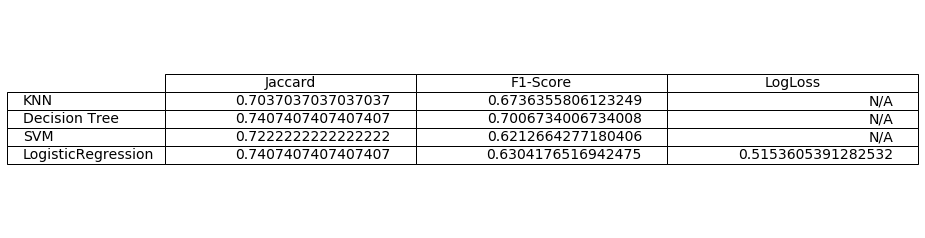

In [274]:
##################################################################################
# Model Performance Evaluation- Outcome Analysis- CLASSIFICATION REPORT
##################################################################################

## Creating arrays of evaluation metrics
KNN=[KNN_Jaccard,KNN_f1, "N/A"]     # LogLoss is not applicable for KNN
DT= [DT_Jaccard, DT_f1, "N/A"]      # LogLoss is not applicable for Decision Tree
SVM= [SVM_Jaccard, SVM_f1, "N/A"]   # LogLoss is not applicable for SVM
LR= [LR_Jaccard, LR_f1, LR_Logloss] # LogLoss is Applicable for Logistic Reg


## Creating a customized table
colLabels = ['Jaccard', 'F1-Score','LogLoss']
rowLabels = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression']
table_vals=[[KNN_Jaccard,KNN_f1, "N/A"],[DT_Jaccard, DT_f1, "N/A"],[SVM_Jaccard, SVM_f1, "N/A"],[LR_Jaccard, LR_f1, LR_Logloss]]
print ('\033[1m' + 'Classification Report of four different Algorithms')
print ("All four approaches predicted the defaults with good precision as shown in the table below:")

the_table = plt.table(cellText=table_vals,
                  colWidths = [0.5]*5,
                  rowLabels=rowLabels,
                  colLabels=colLabels,
                  loc='center')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)
the_table.scale(1.5,1.5)

## Removing ticks and spines to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.savefig('matplotlib-table.png', bbox_inches='tight', pad_inches=0.1)
##################################################################################

### Report- Sample provided by IBM for reference
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?   d   | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>